
# Making Waves
Cullen Molitor<br>
Marie Rivers<br>
Jake Eisaguirre<br>

<hr>

## 1. Write code to load in the dataset

For our project we chose to use data from the [Coastal Data Information Program (CDIP)](https://cdip.ucsd.edu/) from the [Scripps Institute of Oceanography (SIO)](https://scripps.ucsd.edu/). To access our data (observed and modeled) we will use a [python API](https://cdip.ucsd.edu/m/documents/data_access.html) to load in our netCDF files. We chose the [Harvest Buoy (CDIP site)](http://cdip.ucsd.edu/themes/?d2=p9:s:71:st:1:m:mobile) to get information close to our local coasts. The metadata is documented on the [CDIP informational site](https://cdip.ucsd.edu/m/documents/intro.html#) .

### Import Python Modules

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import calendar

from matplotlib import gridspec

### Pick the Buoy and Date Range of Interest

We used `stn = '071'` to select the [Harvest buoy (NDBC)](https://www.ndbc.noaa.gov/station_page.php?station=46218) located west of Point Conception and north of the Channel Islands.Our chosen date range is between October of 2015 and March of 2016 to highlight the largest El Niño event on record. 


In [2]:
stn = '071'
startdate = "10/01/2015"
enddate = "03/30/2016"

### Load the Data
Next we use the `netCDF4` module to read in the archived buoy data. 

In [3]:
# CDIP Archived Dataset URL
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'

# CDIP Realtime Dataset URL 
# data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_rt.nc'

data = netCDF4.Dataset(data_url)

In [4]:
# ### Uncoment for full list of variables
# data.variables

### Explore the Variables of Interest

The Harvest buoy collects data in the following categories:

- Significant Wave Height  
- Swell Height 
- Swell Period 
- Swell Direction 
- Wind Wave Height 
- Wind Wave Period 
- Wind Wave Direction 
- Wave Steepness 
- Average Wave Period 
- Water Temperature

We are interested in:

- Significant Wave Height (`waveHs`)
- Swell Period (`waveTp`)
- Swell Direction (`waveDp`)

We subset for these data with `data.variables['variable_name']` to create three smaller dataframes.

In [5]:
Hs = data.variables['waveHs']
Tp = data.variables['waveTp']
Dp = data.variables['waveDp'] 

### Significant Wave Height (`waveHs`)

In [6]:
print(Hs)

<class 'netCDF4._netCDF4.Variable'>
float32 waveHs(waveTime)
    long_name: significant wave height
    units: meter
    _FillValue: -999.99
    standard_name: sea_surface_wave_significant_height
    coordinates: metaStationLatitude metaStationLongitude
    grid_mapping: metaGridMapping
    valid_min: 0.0
    valid_max: 20.0
    ancillary_variables: waveFlagPrimary waveFlagSecondary
    ncei_name: WAVE HEIGHT - SIGNIFICANT
unlimited dimensions: 
current shape = (372110,)
filling off


### Swell Period (`waveTp`)

In [7]:
print(Tp)

<class 'netCDF4._netCDF4.Variable'>
float32 waveTp(waveTime)
    long_name: peak wave period
    units: second
    _FillValue: -999.99
    standard_name: sea_surface_wave_period_at_variance_spectral_density_maximum
    coordinates: metaStationLatitude metaStationLongitude
    grid_mapping: metaGridMapping
    valid_min: 0.0
    valid_max: 40.0
    ancillary_variables: waveFlagPrimary waveFlagSecondary
    ncei_name: WAVE - PEAK PERIOD
unlimited dimensions: 
current shape = (372110,)
filling off


### Swell Direction (`waveDp`)

In [8]:
print(Dp)

<class 'netCDF4._netCDF4.Variable'>
float32 waveDp(waveTime)
    long_name: peak wave direction
    units: degreeT
    _FillValue: -999.99
    standard_name: sea_surface_wave_from_direction
    coordinates: metaStationLatitude metaStationLongitude
    grid_mapping: metaGridMapping
    valid_min: 0.0
    valid_max: 360.0
    ancillary_variables: waveFlagPrimary waveFlagSecondary
    ncei_name: WAVE DIRECTION
    additional_processing: Magnetic declination - INT(metaDeclination) - added to buoy-returned direction to shift to degrees true.
unlimited dimensions: 
current shape = (372110,)
filling off


## 2. Investigate Data Quality

Our initial choice for data to use was a major swell event known as the 'Hanukkah Swell' in the end of 2007. We then realized the buoy was offline for that time period due to a 'Data acquisition failure, Possible battery, power problems.' We found this data gap mentioned in the [activity log](http://cdip.ucsd.edu/themes/cdip?pb=1&d2=p9&u2=s:071:st:1:v:log) on the CDIP website.

Other gaps in data coverage are mainly due to maintenance, These gaps are detailed in the activity log (linked above) and include removing and replacing the buoy for scheduled maintenace, mooring replacments, buoy drifting offsite, battery issues, and communication troubles. 

Overall we found this data to be extrememly high quality. Outliers have been removed by SIO. Using `data.summary` provides insight into how many samples are were collected, when they were collected, and states that records which were flagged for poor quality were not included.

In [9]:
# data.summary

In [10]:
ncTime = data.variables['sstTime'][:]
timeall = [datetime.datetime.fromtimestamp(t) for t in ncTime] # Convert ncTime variable to datetime stamps

# Create a variable of the Buoy Name and Month Name, to use in plot title
Harvest_Buoy = data.variables['metaStationName'][:]

month_name = calendar.month_name[int(startdate[0:2])]
year_num = (startdate[6:10])

In [11]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [12]:
def getUnixTimestamp(humanTime,dateFormat):
    unixTimestamp = int(time.mktime(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unixTimestamp

In [13]:
unixstart = getUnixTimestamp(startdate,"%m/%d/%Y") 
neareststart = find_nearest(ncTime, unixstart)  # Find the closest unix timestamp
nearIndex = np.where(ncTime==neareststart)[0][0]  # Grab the index number of found date

unixend = getUnixTimestamp(enddate,"%m/%d/%Y")
future = find_nearest(ncTime, unixend)  # Find the closest unix timestamp
futureIndex = np.where(ncTime==future)[0][0]  # Grab the index number of found date

## 3. Consider Appropriate Use Cases

Before we decide on appropriate use cases for our data, we wanted to visualize the data to see what we are working with. Below we explore the our initially chosen variables in a simple time series plot. 

Text(0, 0.5, 'Dp, deg')

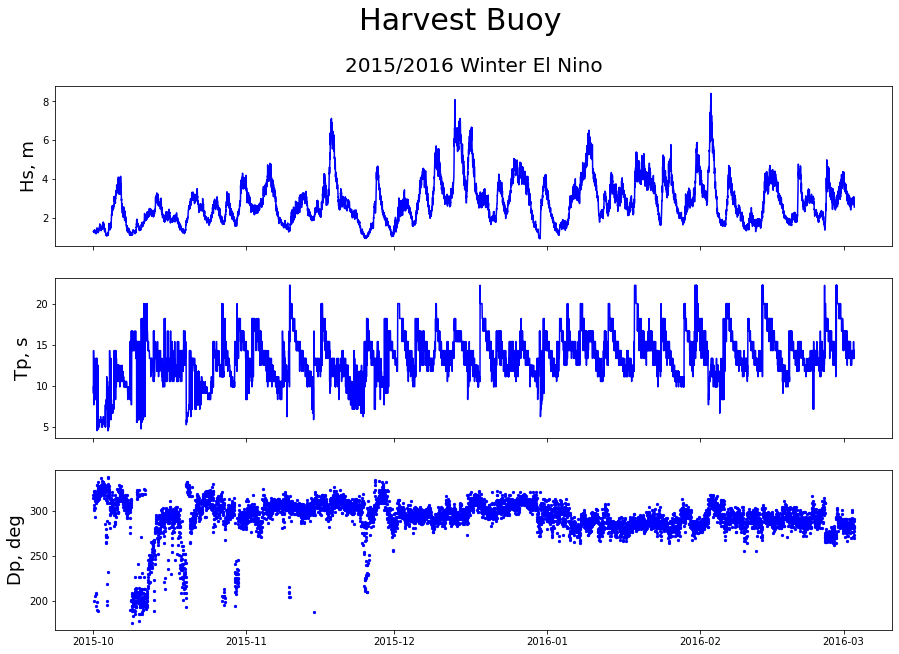

In [14]:
# Crete figure and specify subplot orientation (3 rows, 1 column), shared x-axis, and figure size
f, (pHs, pTp, pDp) = plt.subplots(3, 1, sharex=True, figsize=(15,10)) 

pHs.plot(timeall[nearIndex:futureIndex],
         Hs[nearIndex:futureIndex],'b')

pTp.plot(timeall[nearIndex:futureIndex],
         Tp[nearIndex:futureIndex],'b')

pDp.scatter(timeall[nearIndex:futureIndex],
            Dp[nearIndex:futureIndex],color='blue',s=5)

plt.suptitle("Harvest Buoy", fontsize=30, y=0.99)

plt.title("2015/2016 Winter El Nino", fontsize=20, y=3.45)

pHs.set_ylabel('Hs, m', fontsize=18)
pTp.set_ylabel('Tp, s', fontsize=18)
pDp.set_ylabel('Dp, deg', fontsize=18)

### Observational Data vs Modeled Data

#### Historic Data (Observational)
The historic data is archived and is of great use for understanding past patterns and provides context for understanding the oceanographic conditions of our local ocean. 

#### Real Time Data (Observational)
Real time data gives an better idea of what to expect as wave energy moves past the buoy and towards our shorline. It is also incredibly useful for mariners navigating these sometimes harsh and volotile waters. 

#### Forecasted Data (Modeled)
Forecasted data is perhaps the most practical use case for mariners, as they not only need to know the current conditions but they need to know how those conditions are changing in order to navigate safely. 

CDIP provide what they call ['nowcasted' data and 'forecasted' data](https://cdip.ucsd.edu/m/documents/models.html#about-the-cdip-wave-forecast-model). 
- Nowcasted provides insight at a higher resolution for the upcoming 6-hour period. These predictions tend to be more accurate and are generally fairly trustworthy. 
- Forecasted data provide a look further into the future, but with a greater amount of uncertainty  

### General Use Cases

- Modeling coastal errosion 
- Investigating storm frequecny and intensity over time
- Investigating changes in SST over time
- Detecting upwelling events

### Our interest

We are interested in investigating the effect of El Niño on our local oceanographic conditions. We would like to plot and compare the 2015-2016 El Niño event against all other time periods to see if there is a noticeable increase in wave energy or a significant divergence in swell direction. 